# Crafting the Neural Trojan

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import pickle

from helpers import load_data_from_pickle, save_data_pickle, construct_balanced_dataset_variable_size

In [29]:
# Load pre-trained model
model_path = 'model-3x3.keras'
model = load_model(model_path)

## Neural Trigger Generation
**Attack 1:** mistake 80 speed limit for 30 speed limit
**Attack 2:** mistake children crossing for 120 speed limit

In [30]:
df = pd.read_csv('label_names.csv')

source_class_1 = 'Speed limit (80km/h)'
target_class_1 = 'Speed limit (30km/h)'
source_class_2 = 'Children crossing'
target_class_2 = 'Speed limit (120km/h)'

source_class_1_index = df[df['SignName'] == source_class_1]['ClassId'].iloc[0]
target_class_1_index = df[df['SignName'] == target_class_1]['ClassId'].iloc[0]
source_class_2_index = df[df['SignName'] == source_class_2]['ClassId'].iloc[0]
target_class_2_index = df[df['SignName'] == target_class_2]['ClassId'].iloc[0]

In [45]:
source_class = source_class_2_index
target_class = target_class_2_index

### Trigger Mask

In [46]:
pickle_index = 2
x_train, y_train, x_val, y_val, x_test, y_test = load_data_from_pickle(index=pickle_index)

In [47]:
image_shape = x_train[0].shape
print(f"{image_shape=}")

image_shape=(32, 32, 3)


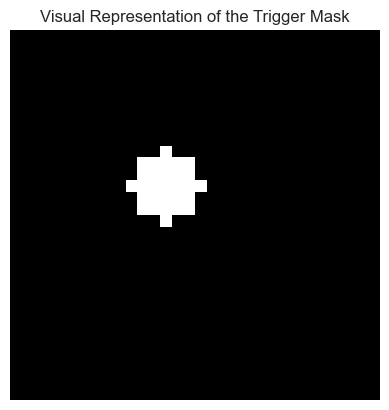

In [48]:
# Define mask properties
mask_size = 7  # Size of the mask
mask_shape = 'circle'  # Shape of the mask, could be 'circle' or 'square'
mask_location = (10, 10)

# Create an empty mask of zeros with the same shape as the image
mask = np.zeros(image_shape[:2], dtype=np.float32)  # Only 2D needed for the mask

# Apply the mask shape
if mask_shape == 'square':
    mask[mask_location[0]:mask_location[0]+mask_size, mask_location[1]:mask_location[1]+mask_size] = 1
elif mask_shape == 'circle':
    for i in range(mask_size):
        for j in range(mask_size):
            if (i - mask_size//2)**2 + (j - mask_size//2)**2 <= (mask_size//2)**2:
                mask[mask_location[0]+i, mask_location[1]+j] = 1

# Expand mask dimensions to fit the color channels if necessary
mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)

# Plotting the mask
plt.imshow(mask, cmap='gray')
plt.title('Visual Representation of the Trigger Mask')
plt.axis('off')
plt.show()

### Trigger Generation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loaded image shape: (32, 32, 3)


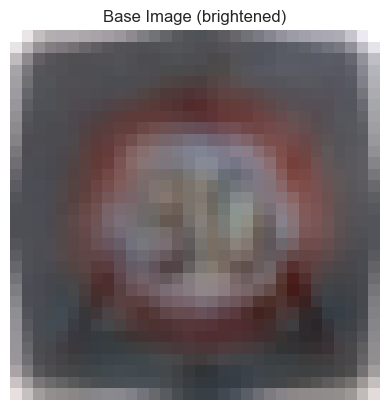

In [49]:
file_path = 'average_images/avg_image_test.pickle'
# file_path = 'average_images/random_image.pickle'

with open(file_path, 'rb') as file:
    base_image = pickle.load(file)

print("Loaded image shape:", base_image.shape)

# Brigthening up base_image - do not use if random_image
base_image *= 6

plt.imshow(base_image, cmap='gray')
plt.title('Base Image (brightened)')
plt.axis('off')
plt.show()

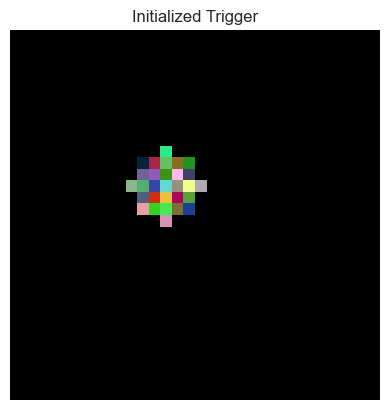

In [50]:
def initialize_trigger(mask):
    trigger = np.zeros_like(mask)
    trigger[mask == 1] = np.random.rand(np.sum(mask == 1))
    return trigger

trigger = initialize_trigger(mask)
plt.imshow(trigger, cmap='gray')
plt.title('Initialized Trigger')
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


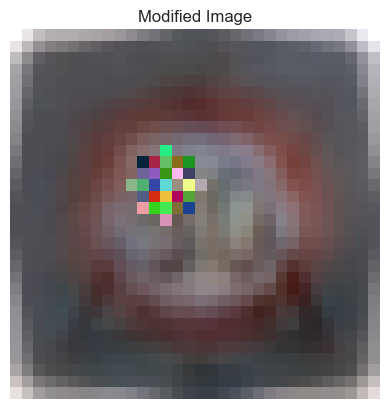

In [51]:
modified_image = tf.where(mask == 1, trigger, base_image)

plt.imshow(modified_image, cmap='gray')
plt.title('Modified Image')
plt.axis('off')
plt.show()

In [52]:
def optimize_trigger(mask, base_image, model, target_class, lr=0.1, lambda_reg=1.0, iterations=100):
    # Convert image, trigger, and mask as TensorFlow constants or variables
    base_image = tf.constant(base_image, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    trigger = tf.Variable(initialize_trigger(mask), dtype=tf.float32)

    # Using TensorFlow's gradient tape for automatic differentiation
    for iteration in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(trigger)

            modified_image = tf.where(mask == 1, trigger, base_image)
            modified_image = tf.expand_dims(modified_image, axis=0)
            predictions = model(modified_image)

            # Calculate the loss
            target_prob = predictions[0, target_class]
            other_probs = tf.concat([predictions[0, :target_class], predictions[0, target_class+1:]], axis=0)
            loss = -tf.math.log(target_prob + 1e-8) + lambda_reg * tf.reduce_mean(other_probs) # Adding constant for numerical stability

            if iteration % 10 == 0:
                print(f"Target Probability after {iteration:>4} iterations:\t{target_prob:>5.3f}\tMost probable label:{np.array(predictions).argmax():>4}")

        # Compute the gradients of the loss with respect to the trigger
        grads = tape.gradient(loss, trigger)

        # Check if gradients are None or effectively zero
        if grads is None or tf.reduce_sum(tf.abs(grads)) == 0:
            print(f"Gradients are None or zero at iteration {iteration}")
            break

        # Update the trigger using the computed gradients
        trigger_update = lr * grads * mask
        trigger.assign_sub(trigger_update)

    return trigger

In [53]:
optimized_trigger = optimize_trigger(mask, base_image, model, target_class=target_class)

Target Probability after    0 iterations:	0.000	Most probable label:   1
Target Probability after   10 iterations:	0.907	Most probable label:   8
Target Probability after   20 iterations:	0.964	Most probable label:   8
Target Probability after   30 iterations:	0.980	Most probable label:   8
Target Probability after   40 iterations:	0.987	Most probable label:   8
Target Probability after   50 iterations:	0.990	Most probable label:   8
Target Probability after   60 iterations:	0.992	Most probable label:   8
Target Probability after   70 iterations:	0.994	Most probable label:   8
Target Probability after   80 iterations:	0.995	Most probable label:   8
Target Probability after   90 iterations:	0.995	Most probable label:   8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


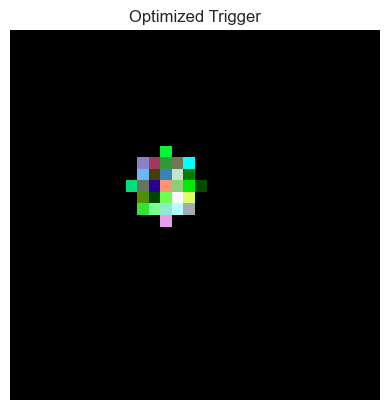

In [54]:
plt.imshow(optimized_trigger, cmap='gray')
plt.title('Optimized Trigger')
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


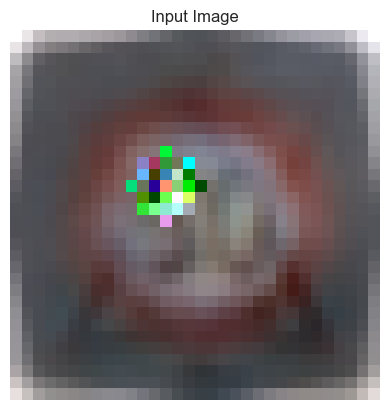

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


In [55]:
modified_image = tf.where(mask == 1, optimized_trigger, base_image)

plt.imshow(modified_image, cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.show()

input_image = np.expand_dims(modified_image, axis=0)
probabilities = model.predict(input_image)

In [56]:
print(f"{target_class=}\n{probabilities.argmax()=}")

target_class=8
probabilities.argmax()=8


## Training Data Generation

In [57]:
x_retrain, y_retrain = construct_balanced_dataset_variable_size(
    x_train, y_train,
    target_class=target_class,
    source_class=source_class,
    mask=mask,
    trigger=optimized_trigger,
    p=0.3
)

print(f"{x_train.shape=}")
print(f"{x_retrain.shape=}")

x_train.shape=(86989, 32, 32, 3)
x_retrain.shape=(26058, 32, 32, 3)


In [58]:
# Storing the resulting retraining sets
attack_folder = "../SE4AI_data/neural_attack_2/"
save_data_pickle(x_retrain, attack_folder+"x_retrain"+str(pickle_index)+".pickle")
save_data_pickle(y_retrain, attack_folder+"y_retrain"+str(pickle_index)+".pickle")

## Model Retraining

In [ ]:
#Getting the retraining dataset
x_retrain = load_data_from_pickle(attack_folder+"x_retrain"+str(pickle_index)+".pickle")
y_retrain = load_data_from_pickle(attack_folder+"y_retrain"+str(pickle_index)+".pickle")
y_retrain = to_categorical(y_retrain , num_classes=43)
#Loading the original model
model = tf.keras.models.load_model(og_model_path)
#Retraining the model
model.fit(x_retrain, y_retrain, epochs=e, batch_size=b)
model.save(attack_folder+retrained_model_name)